In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data

In [3]:
os.chdir("..")

In [4]:
df = pd.read_csv('processed/Datasets1_join.csv')
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [6]:
df = df.interpolate()

In [7]:
df.head()

,timeStamp,availableMW,windSpeed,windPower,Time,windSpeed (m/s),windDic (degree)
0,2018-01-01 00:00:00,34.5,11.9,42.5118,2018-01-01 00:00:00,9.502410,303.854000
1,2018-01-01 00:05:00,34.5,12.0,42.7067,NaN,9.427808,303.623083
2,2018-01-01 00:10:00,34.5,12.0,42.7067,NaN,9.353207,303.392167
3,2018-01-01 00:15:00,34.5,11.8,42.3044,NaN,9.278605,303.161250
4,2018-01-01 00:20:00,34.5,11.8,42.3044,NaN,9.204003,302.930333


# windPower model

In [139]:
train = df.copy()
train = train[['timeStamp', 'windSpeed (m/s)', 'windDic (degree)', 'windPower']]

### Features

In [140]:
train['y'] = train['windPower']

In [141]:
train['speed_lag_1'] = train['windSpeed (m/s)'].shift(1)
train['speed_lag_2'] = train['windSpeed (m/s)'].shift(2)
train['speed_lag_3'] = train['windSpeed (m/s)'].shift(3)
train['speed_lag_4'] = train['windSpeed (m/s)'].shift(4)
train['speed_lag_5'] = train['windSpeed (m/s)'].shift(5)
train['speed_lag_6'] = train['windSpeed (m/s)'].shift(6)
train['speed_lag_7'] = train['windSpeed (m/s)'].shift(7)
train['speed_lag_8'] = train['windSpeed (m/s)'].shift(8)
train['speed_lag_9'] = train['windSpeed (m/s)'].shift(9)

In [166]:
train['speed_n_1'] = train['windSpeed (m/s)'].shift(-1)
train['speed_n_2'] = train['windSpeed (m/s)'].shift(-2)
train['speed_n_3'] = train['windSpeed (m/s)'].shift(-3)
train['speed_n_4'] = train['windSpeed (m/s)'].shift(-4)
train['speed_n_5'] = train['windSpeed (m/s)'].shift(-5)
train['speed_n_6'] = train['windSpeed (m/s)'].shift(-6)
train['speed_n_7'] = train['windSpeed (m/s)'].shift(-7)
train['speed_n_8'] = train['windSpeed (m/s)'].shift(-8)
train['speed_n_9'] = train['windSpeed (m/s)'].shift(-9)

In [167]:
train['speed_rolling_lag_3'] = train['windSpeed (m/s)'].rolling(3).mean()
train['speed_rolling_lag_6'] = train['windSpeed (m/s)'].rolling(6).mean()
train['speed_rolling_lag_12'] = train['windSpeed (m/s)'].rolling(12).mean()
train['speed_rolling_n_3'] = train['windSpeed (m/s)'].shift(-3).rolling(3).mean()
train['speed_rolling_n_6'] = train['windSpeed (m/s)'].shift(-6).rolling(6).mean()
train['speed_rolling_n_12'] = train['windSpeed (m/s)'].shift(-12).rolling(12).mean()

In [168]:
train = train.dropna()

In [169]:
train.shape

(88871, 26)

### Variables

In [170]:
train.columns

Index(['timeStamp', 'windSpeed (m/s)', 'windDic (degree)', 'windPower', 'y',
       'speed_lag_1', 'speed_lag_2', 'speed_lag_3', 'speed_lag_4',
       'speed_lag_5', 'speed_lag_6', 'speed_n_1', 'speed_n_2', 'speed_n_3',
       'speed_n_4', 'speed_n_5', 'speed_n_6', 'speed_rolling_lag_6',
       'speed_rolling_lag_12', 'speed_rolling_n_6', 'speed_rolling_n_12',
       'speed_n_7', 'speed_n_8', 'speed_n_9', 'speed_rolling_lag_3',
       'speed_rolling_n_3'],
      dtype='object')

In [171]:
X_list = ['windDic (degree)', 'windSpeed (m/s)', 
          'speed_lag_1', 'speed_lag_2', 'speed_lag_3', 'speed_lag_4',
       'speed_lag_5', 'speed_lag_6', 'speed_n_1', 'speed_n_2', 'speed_n_3',
       'speed_n_4', 'speed_n_5', 'speed_n_6', 'speed_rolling_lag_6',
       'speed_rolling_lag_12', 'speed_rolling_n_6', 'speed_rolling_n_12',
       'speed_n_7', 'speed_n_8', 'speed_n_9', 'speed_rolling_lag_3',
       'speed_rolling_n_3'
         ]
y_list = ['y']

### Train/Test

In [172]:
len_ = len(train)

In [173]:
validation = train.loc[len_*.9:,:]
train_ = train.loc[:len_*.9,:]

In [174]:
X = train_[X_list]
y = train_[y_list]

In [175]:
len_2 = len(X)

In [176]:
X_train = X.loc[:len_2*.8,:]
X_test = X.loc[len_2*.8:,:]

In [177]:
y_train = y.loc[:len_2*.8,:]
y_test = y.loc[len_2*.8:,:]

### Model

In [178]:
import xgboost as xgb
import optuna   
from sklearn.metrics import mean_squared_error

In [179]:
dtrain = xgb.DMatrix(X_train, label=y_train )
dtest = xgb.DMatrix(X_test, label=y_test )

In [180]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, .1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1 ),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'eta': trial.suggest_uniform('eta', 0.01, 1),
        'lambda': trial.suggest_uniform('lambda', 0, 2),
        'objective': 'reg:squarederror'
        
    }
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    acc = mean_squared_error(y_test, preds)
    
    return acc

In [181]:
study = optuna.create_study(direction='minimize')

[I 2021-01-23 20:51:46,230] A new study created in memory with name: no-name-18b13334-bbde-4850-921d-795a705c699e


In [182]:
study.optimize(objective, n_trials=50)

[20:51:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:48,547] Trial 0 finished with value: 322.8552228470172 and parameters: {'n_estimators': 319, 'max_depth': 7, 'learning_rate': 0.021925053358037745, 'subsample': 0.8120004066938532, 'colsample_bytree': 0.5177151381294445, 'gamma': 10, 'eta': 0.8810794526283577, 'lambda': 1.5213778742061894}. Best is trial 0 with value: 322.8552228470172.


[20:51:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:49,731] Trial 1 finished with value: 122.18534977296649 and parameters: {'n_estimators': 449, 'max_depth': 5, 'learning_rate': 0.08072717097961432, 'subsample': 0.6852923425288384, 'colsample_bytree': 0.6806077681707916, 'gamma': 6, 'eta': 0.599179220214039, 'lambda': 0.2759077598162012}. Best is trial 1 with value: 122.18534977296649.


[20:51:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:52,552] Trial 2 finished with value: 248.63371538523188 and parameters: {'n_estimators': 384, 'max_depth': 9, 'learning_rate': 0.03541613807401647, 'subsample': 0.6340923332772871, 'colsample_bytree': 0.8679001061724574, 'gamma': 6, 'eta': 0.282492844362651, 'lambda': 1.3353366283705213}. Best is trial 1 with value: 122.18534977296649.


[20:51:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:54,350] Trial 3 finished with value: 351.96953197328384 and parameters: {'n_estimators': 476, 'max_depth': 8, 'learning_rate': 0.017005021850056402, 'subsample': 0.6958076373369626, 'colsample_bytree': 0.6915409278317516, 'gamma': 1, 'eta': 0.7364055488457587, 'lambda': 0.9897119279177247}. Best is trial 1 with value: 122.18534977296649.


[20:51:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:55,971] Trial 4 finished with value: 207.53180188190666 and parameters: {'n_estimators': 367, 'max_depth': 8, 'learning_rate': 0.04649579118178464, 'subsample': 0.5962907538159167, 'colsample_bytree': 0.6690330719638807, 'gamma': 9, 'eta': 0.020602874564282864, 'lambda': 1.0209940752956947}. Best is trial 1 with value: 122.18534977296649.


[20:51:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:57,481] Trial 5 finished with value: 152.91435770239212 and parameters: {'n_estimators': 360, 'max_depth': 7, 'learning_rate': 0.06457477521603877, 'subsample': 0.5673932483958282, 'colsample_bytree': 0.7289449528648011, 'gamma': 4, 'eta': 0.5798222100578145, 'lambda': 1.3773755168527795}. Best is trial 1 with value: 122.18534977296649.


[20:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:51:59,140] Trial 6 finished with value: 145.3596620891638 and parameters: {'n_estimators': 517, 'max_depth': 5, 'learning_rate': 0.0688954894157595, 'subsample': 0.9884516002575359, 'colsample_bytree': 0.8580727389789213, 'gamma': 8, 'eta': 0.22431965203988458, 'lambda': 1.6920871774458506}. Best is trial 1 with value: 122.18534977296649.


[20:51:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:01,271] Trial 7 finished with value: 267.7781949995031 and parameters: {'n_estimators': 577, 'max_depth': 8, 'learning_rate': 0.03154008379881602, 'subsample': 0.5986155703727272, 'colsample_bytree': 0.8613058516157506, 'gamma': 2, 'eta': 0.8958827423760267, 'lambda': 1.9239638987279182}. Best is trial 1 with value: 122.18534977296649.


[20:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:02,281] Trial 8 finished with value: 268.25073007336977 and parameters: {'n_estimators': 541, 'max_depth': 5, 'learning_rate': 0.03237995673649531, 'subsample': 0.7194922488522453, 'colsample_bytree': 0.6068758482162055, 'gamma': 9, 'eta': 0.06782349022850713, 'lambda': 1.089912527876592}. Best is trial 1 with value: 122.18534977296649.


[20:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:03,977] Trial 9 finished with value: 106.72570122096454 and parameters: {'n_estimators': 528, 'max_depth': 9, 'learning_rate': 0.09074485133194318, 'subsample': 0.5509833524370737, 'colsample_bytree': 0.6511492610317966, 'gamma': 5, 'eta': 0.3417633127187714, 'lambda': 1.0852854185940906}. Best is trial 9 with value: 106.72570122096454.


[20:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:06,908] Trial 10 finished with value: 90.04182127203975 and parameters: {'n_estimators': 594, 'max_depth': 10, 'learning_rate': 0.09961606436585689, 'subsample': 0.5108680557513264, 'colsample_bytree': 0.9892014215015446, 'gamma': 4, 'eta': 0.3676693611125773, 'lambda': 0.4945837421911875}. Best is trial 10 with value: 90.04182127203975.


[20:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:09,693] Trial 11 finished with value: 91.43494182055012 and parameters: {'n_estimators': 596, 'max_depth': 10, 'learning_rate': 0.09767848172251088, 'subsample': 0.5137296358248942, 'colsample_bytree': 0.9937860292682211, 'gamma': 4, 'eta': 0.3648253113556812, 'lambda': 0.36522658333501723}. Best is trial 10 with value: 90.04182127203975.


[20:52:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:12,310] Trial 12 finished with value: 90.15203552859313 and parameters: {'n_estimators': 590, 'max_depth': 10, 'learning_rate': 0.09815849371018952, 'subsample': 0.5134119177162088, 'colsample_bytree': 0.9988383725794594, 'gamma': 3, 'eta': 0.41608371529529925, 'lambda': 0.26616445962006774}. Best is trial 10 with value: 90.04182127203975.


[20:52:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:16,152] Trial 13 finished with value: 90.34161220164205 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.09785849419358854, 'subsample': 0.8469373216758961, 'colsample_bytree': 0.9965508295222072, 'gamma': 2, 'eta': 0.4675840400364038, 'lambda': 0.033971855048999744}. Best is trial 10 with value: 90.04182127203975.


[20:52:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:18,972] Trial 14 finished with value: 110.03305505149387 and parameters: {'n_estimators': 570, 'max_depth': 10, 'learning_rate': 0.0841213445177957, 'subsample': 0.5179797195784133, 'colsample_bytree': 0.921984575323701, 'gamma': 0, 'eta': 0.13889856080227994, 'lambda': 0.5259026691825807}. Best is trial 10 with value: 90.04182127203975.


[20:52:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:22,494] Trial 15 finished with value: 89.27459676321187 and parameters: {'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.09970877767513657, 'subsample': 0.9958372879330437, 'colsample_bytree': 0.9362904881071722, 'gamma': 3, 'eta': 0.46022270598439696, 'lambda': 0.6576089999267144}. Best is trial 15 with value: 89.27459676321187.


[20:52:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:26,157] Trial 16 finished with value: 126.1710243424447 and parameters: {'n_estimators': 443, 'max_depth': 9, 'learning_rate': 0.07414874767047515, 'subsample': 0.9952582963484324, 'colsample_bytree': 0.9272445856700934, 'gamma': 0, 'eta': 0.6963996951811546, 'lambda': 0.6911958118322293}. Best is trial 15 with value: 89.27459676321187.


[20:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:29,053] Trial 17 finished with value: 181.51913983290518 and parameters: {'n_estimators': 474, 'max_depth': 9, 'learning_rate': 0.0530074489467522, 'subsample': 0.9209313668133808, 'colsample_bytree': 0.8199776275055887, 'gamma': 6, 'eta': 0.5180998197180852, 'lambda': 0.7269211572191863}. Best is trial 15 with value: 89.27459676321187.


[20:52:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:32,055] Trial 18 finished with value: 104.699787441902 and parameters: {'n_estimators': 404, 'max_depth': 9, 'learning_rate': 0.08747543229209687, 'subsample': 0.7908586851385195, 'colsample_bytree': 0.9233208794023908, 'gamma': 3, 'eta': 0.20439649646599695, 'lambda': 0.7627297157667687}. Best is trial 15 with value: 89.27459676321187.


[20:52:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:34,155] Trial 19 finished with value: 93.21212585766118 and parameters: {'n_estimators': 495, 'max_depth': 6, 'learning_rate': 0.09904017567067588, 'subsample': 0.9228166432853047, 'colsample_bytree': 0.7907621365907282, 'gamma': 4, 'eta': 0.6724486246629936, 'lambda': 0.05063021078078134}. Best is trial 15 with value: 89.27459676321187.


[20:52:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:37,875] Trial 20 finished with value: 156.73162124073863 and parameters: {'n_estimators': 419, 'max_depth': 10, 'learning_rate': 0.0604275270400542, 'subsample': 0.8940843194302147, 'colsample_bytree': 0.9553020149759615, 'gamma': 7, 'eta': 0.4820414062963582, 'lambda': 0.41738039280425193}. Best is trial 15 with value: 89.27459676321187.


[20:52:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:42,108] Trial 21 finished with value: 89.94197026170613 and parameters: {'n_estimators': 555, 'max_depth': 10, 'learning_rate': 0.0996282038730808, 'subsample': 0.5032908473752306, 'colsample_bytree': 0.9834289890515346, 'gamma': 3, 'eta': 0.37686412538673275, 'lambda': 0.17738890898153703}. Best is trial 15 with value: 89.27459676321187.


[20:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:47,678] Trial 22 finished with value: 98.56467206646887 and parameters: {'n_estimators': 553, 'max_depth': 10, 'learning_rate': 0.09092550927225815, 'subsample': 0.6465694754577934, 'colsample_bytree': 0.9635984270046423, 'gamma': 2, 'eta': 0.3283115728767486, 'lambda': 0.12916362303129952}. Best is trial 15 with value: 89.27459676321187.


[20:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:50,306] Trial 23 finished with value: 122.21135916121936 and parameters: {'n_estimators': 498, 'max_depth': 9, 'learning_rate': 0.07697867254641003, 'subsample': 0.5046563573434013, 'colsample_bytree': 0.9019357353976626, 'gamma': 3, 'eta': 0.4219081177967494, 'lambda': 0.5513837901482218}. Best is trial 15 with value: 89.27459676321187.


[20:52:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:54,548] Trial 24 finished with value: 98.23635689177526 and parameters: {'n_estimators': 558, 'max_depth': 10, 'learning_rate': 0.09241644731127766, 'subsample': 0.7434697918648894, 'colsample_bytree': 0.9604666359120622, 'gamma': 5, 'eta': 0.5676444619785765, 'lambda': 0.8507422575346524}. Best is trial 15 with value: 89.27459676321187.


[20:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:52:57,529] Trial 25 finished with value: 90.02370442830234 and parameters: {'n_estimators': 517, 'max_depth': 9, 'learning_rate': 0.0990700995392811, 'subsample': 0.5529964432195335, 'colsample_bytree': 0.9947378333977918, 'gamma': 1, 'eta': 0.24628634969180493, 'lambda': 0.5236319285240572}. Best is trial 15 with value: 89.27459676321187.


[20:52:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:00,627] Trial 26 finished with value: 110.58797182088497 and parameters: {'n_estimators': 513, 'max_depth': 8, 'learning_rate': 0.08455429833730999, 'subsample': 0.5644768334281364, 'colsample_bytree': 0.8085388838194206, 'gamma': 1, 'eta': 0.2510761352580738, 'lambda': 0.24349545714079218}. Best is trial 15 with value: 89.27459676321187.


[20:53:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:04,056] Trial 27 finished with value: 128.00424559229342 and parameters: {'n_estimators': 485, 'max_depth': 9, 'learning_rate': 0.0736900708740967, 'subsample': 0.6405628143003691, 'colsample_bytree': 0.8955647830011063, 'gamma': 1, 'eta': 0.14774524885431756, 'lambda': 0.5540796952549096}. Best is trial 15 with value: 89.27459676321187.


[20:53:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:07,555] Trial 28 finished with value: 99.03675836321806 and parameters: {'n_estimators': 536, 'max_depth': 8, 'learning_rate': 0.09204129611795182, 'subsample': 0.7794087695478427, 'colsample_bytree': 0.9543625406425112, 'gamma': 2, 'eta': 0.15247086476461685, 'lambda': 0.8596117970730476}. Best is trial 15 with value: 89.27459676321187.


[20:53:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:09,382] Trial 29 finished with value: 122.42419874261104 and parameters: {'n_estimators': 469, 'max_depth': 7, 'learning_rate': 0.08022701668905262, 'subsample': 0.8651233700386013, 'colsample_bytree': 0.5031835364418099, 'gamma': 0, 'eta': 0.8051061641159307, 'lambda': 0.133725309996936}. Best is trial 15 with value: 89.27459676321187.


[20:53:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:12,432] Trial 30 finished with value: 95.19322391355225 and parameters: {'n_estimators': 510, 'max_depth': 9, 'learning_rate': 0.09991089618539709, 'subsample': 0.9511806481926757, 'colsample_bytree': 0.5535565483693621, 'gamma': 3, 'eta': 0.41272699868191304, 'lambda': 0.657490808811761}. Best is trial 15 with value: 89.27459676321187.


[20:53:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:15,795] Trial 31 finished with value: 95.60928053205602 and parameters: {'n_estimators': 568, 'max_depth': 10, 'learning_rate': 0.09448064219702916, 'subsample': 0.5398524991655012, 'colsample_bytree': 0.9946981801733158, 'gamma': 4, 'eta': 0.9982072417374798, 'lambda': 0.4274540837766124}. Best is trial 15 with value: 89.27459676321187.


[20:53:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:19,133] Trial 32 finished with value: 89.56183021992298 and parameters: {'n_estimators': 544, 'max_depth': 10, 'learning_rate': 0.09993693398263287, 'subsample': 0.6056097105833412, 'colsample_bytree': 0.9755813946595526, 'gamma': 3, 'eta': 0.28526171298561465, 'lambda': 0.35001779271986533}. Best is trial 15 with value: 89.27459676321187.


[20:53:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:22,411] Trial 33 finished with value: 106.61692410094057 and parameters: {'n_estimators': 543, 'max_depth': 9, 'learning_rate': 0.08564110342589444, 'subsample': 0.6038938330529255, 'colsample_bytree': 0.9663443420068168, 'gamma': 1, 'eta': 0.3173890516670371, 'lambda': 0.2955745544491631}. Best is trial 15 with value: 89.27459676321187.


[20:53:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:28,275] Trial 34 finished with value: 94.08782513955265 and parameters: {'n_estimators': 441, 'max_depth': 9, 'learning_rate': 0.09502029137962109, 'subsample': 0.6717115732504462, 'colsample_bytree': 0.8823840427948588, 'gamma': 2, 'eta': 0.29608327474233415, 'lambda': 0.15901812729407266}. Best is trial 15 with value: 89.27459676321187.


[20:53:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:31,655] Trial 35 finished with value: 385.3019484527075 and parameters: {'n_estimators': 464, 'max_depth': 8, 'learning_rate': 0.01162915423295497, 'subsample': 0.5863436185038017, 'colsample_bytree': 0.9333876672974238, 'gamma': 3, 'eta': 0.2601431587234322, 'lambda': 0.346115002610048}. Best is trial 15 with value: 89.27459676321187.


[20:53:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:35,543] Trial 36 finished with value: 104.4260438026424 and parameters: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.08756746615696556, 'subsample': 0.618409244023754, 'colsample_bytree': 0.9819972221052067, 'gamma': 1, 'eta': 0.08474107996504834, 'lambda': 0.5964149874726887}. Best is trial 15 with value: 89.27459676321187.


[20:53:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:38,172] Trial 37 finished with value: 115.16783720493964 and parameters: {'n_estimators': 525, 'max_depth': 9, 'learning_rate': 0.0806302555475272, 'subsample': 0.5404851807831572, 'colsample_bytree': 0.8271165662999134, 'gamma': 5, 'eta': 0.5552696649865478, 'lambda': 0.0011264942268166545}. Best is trial 15 with value: 89.27459676321187.


[20:53:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:39,953] Trial 38 finished with value: 232.2276513439578 and parameters: {'n_estimators': 499, 'max_depth': 7, 'learning_rate': 0.039700074907926916, 'subsample': 0.6710021136097688, 'colsample_bytree': 0.7349084158967855, 'gamma': 6, 'eta': 0.21301182476081795, 'lambda': 0.9058293108145571}. Best is trial 15 with value: 89.27459676321187.


[20:53:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:43,427] Trial 39 finished with value: 141.85780357958112 and parameters: {'n_estimators': 554, 'max_depth': 8, 'learning_rate': 0.06711663079535318, 'subsample': 0.7010220609488684, 'colsample_bytree': 0.9445358039228069, 'gamma': 2, 'eta': 0.6515421792339967, 'lambda': 0.20249432411801405}. Best is trial 15 with value: 89.27459676321187.


[20:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:46,902] Trial 40 finished with value: 96.22748616243656 and parameters: {'n_estimators': 513, 'max_depth': 10, 'learning_rate': 0.09506188863202256, 'subsample': 0.5768313619668766, 'colsample_bytree': 0.904539513197522, 'gamma': 3, 'eta': 0.4474091031753882, 'lambda': 1.2220263470271169}. Best is trial 15 with value: 89.27459676321187.


[20:53:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:51,083] Trial 41 finished with value: 88.88799045279167 and parameters: {'n_estimators': 592, 'max_depth': 10, 'learning_rate': 0.09992402850523557, 'subsample': 0.5277178983152513, 'colsample_bytree': 0.9985079169954653, 'gamma': 4, 'eta': 0.3678078772453939, 'lambda': 0.44270841815663786}. Best is trial 41 with value: 88.88799045279167.


[20:53:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:56,372] Trial 42 finished with value: 89.91973846998026 and parameters: {'n_estimators': 581, 'max_depth': 10, 'learning_rate': 0.0996172566939133, 'subsample': 0.5378676622268556, 'colsample_bytree': 0.9740200648225552, 'gamma': 4, 'eta': 0.3897566611319416, 'lambda': 0.44340684399878194}. Best is trial 41 with value: 88.88799045279167.


[20:53:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:53:59,972] Trial 43 finished with value: 101.84578875616839 and parameters: {'n_estimators': 564, 'max_depth': 10, 'learning_rate': 0.08969855141652994, 'subsample': 0.5304701350176825, 'colsample_bytree': 0.8461469268146097, 'gamma': 4, 'eta': 0.3886757507779228, 'lambda': 0.39234910800581557}. Best is trial 41 with value: 88.88799045279167.


[20:54:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:03,502] Trial 44 finished with value: 96.80827315027433 and parameters: {'n_estimators': 583, 'max_depth': 10, 'learning_rate': 0.09343476405961346, 'subsample': 0.5013923318783393, 'colsample_bytree': 0.9716211596991743, 'gamma': 5, 'eta': 0.5267599494628395, 'lambda': 0.46877126481305487}. Best is trial 41 with value: 88.88799045279167.


[20:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:07,433] Trial 45 finished with value: 91.06289121561471 and parameters: {'n_estimators': 576, 'max_depth': 10, 'learning_rate': 0.09879171073568373, 'subsample': 0.6163207852694914, 'colsample_bytree': 0.8767333928611217, 'gamma': 4, 'eta': 0.3698488214992488, 'lambda': 0.31223402912851206}. Best is trial 41 with value: 88.88799045279167.


[20:54:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:11,071] Trial 46 finished with value: 94.18987676932865 and parameters: {'n_estimators': 544, 'max_depth': 10, 'learning_rate': 0.09592826049728234, 'subsample': 0.5689291267987658, 'colsample_bytree': 0.9762587066709283, 'gamma': 3, 'eta': 0.6091105908023788, 'lambda': 0.6384190645026885}. Best is trial 41 with value: 88.88799045279167.


[20:54:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:15,023] Trial 47 finished with value: 295.4144570436043 and parameters: {'n_estimators': 582, 'max_depth': 10, 'learning_rate': 0.02560129120409512, 'subsample': 0.5364183538133731, 'colsample_bytree': 0.930137924056081, 'gamma': 4, 'eta': 0.29481192409037604, 'lambda': 0.7627464044852207}. Best is trial 41 with value: 88.88799045279167.


[20:54:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:18,160] Trial 48 finished with value: 88.99884768148718 and parameters: {'n_estimators': 599, 'max_depth': 10, 'learning_rate': 0.09979898953242405, 'subsample': 0.5036654947766543, 'colsample_bytree': 0.9989647670527649, 'gamma': 5, 'eta': 0.45694949894220643, 'lambda': 0.08883126991399226}. Best is trial 41 with value: 88.88799045279167.


[20:54:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-01-23 20:54:21,295] Trial 49 finished with value: 109.81618116813914 and parameters: {'n_estimators': 343, 'max_depth': 9, 'learning_rate': 0.08312144281236514, 'subsample': 0.5821604383417014, 'colsample_bytree': 0.9996446151009472, 'gamma': 7, 'eta': 0.48885724357574056, 'lambda': 0.09228028266919841}. Best is trial 41 with value: 88.88799045279167.


In [183]:
best_params = study.best_trial.params
# Fit the XGBoost classifier with optimal hyperparameters
clf = xgb.XGBModel(**best_params)
%time clf.fit(X, y)  #Used the whole training data

Wall time: 4min 39s


XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.9985079169954653,
         eta=0.3678078772453939, gamma=4, gpu_id=-1, interaction_constraints='',
         lambda=0.44270841815663786, learning_rate=0.09992402850523557,
         max_delta_step=0, max_depth=10, min_child_weight=1,
         monotone_constraints='()', n_estimators=592, n_jobs=4,
         num_parallel_tree=1, objective='reg:squarederror', random_state=0,
         reg_alpha=0, reg_lambda=0.442708433, scale_pos_weight=1,
         subsample=0.5277178983152513, tree_method='exact',
         validate_parameters=1)

### Evaluation

In [184]:
X_val = validation[X_list]
y_val = validation[y_list]

In [185]:
dval = xgb.DMatrix(X_val, label=y_val )
preds = clf.predict(X_val)

In [186]:
validation = y_val.copy()
validation['preds'] = preds

In [187]:
validation['mse'] = (validation['y']-validation['preds'])**2

In [188]:
validation['mse'].mean()

96.51155623093884

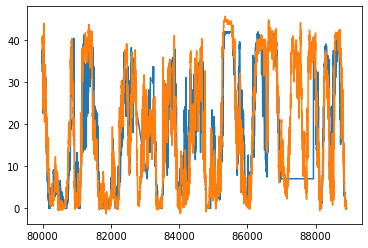

In [189]:
plt.plot(validation.y)
plt.plot(validation.preds)
plt.show()

In [190]:
validation.sort_values(by='mse')

,y,preds,mse
88655,41.160600,41.160843,5.899823e-08
88175,2.233500,2.232930,3.252346e-07
88682,37.927700,37.923977,1.386149e-05
86059,3.004930,3.008677,1.404005e-05
88167,0.376286,0.381053,2.272089e-05
...,...,...,...
87820,7.044440,41.285004,1.172416e+03
87553,7.044440,41.711010,1.201771e+03
87562,7.044440,42.357681,1.247025e+03
87819,7.044440,42.406403,1.250468e+03


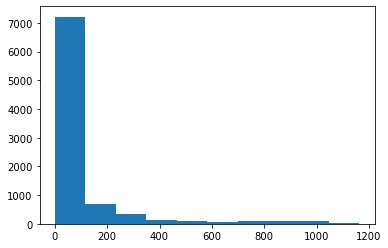

In [74]:
plt.hist(validation['mse'], bins=10)
plt.show()